#### Imports

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from lambeq import BobcatParser, Rewriter, IQPAnsatz
from torchvision import models, transforms
from PIL import Image
import requests
from PIL import Image
import numpy as np
import io
import pandas as pd

from lambeq.backend.grammar import Box, Id, Ty, Diagram

#### Extract first row from csv file

In [2]:
# Read the CSV file
file_path = os.path.join(os.getcwd(), "database.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence'].iloc[0]
image_pos = df['pos_url'].iloc[0]
image_neg = df['neg_url'].iloc[0]

# Print the first row
print(f"Sentence: {sentence} ")
print(f"Image Pos: {image_pos}")
print(f"Image Neg: {image_neg}")

Sentence: A woman sits in a field. 
Image Pos: https://previews.123rf.com/images/studio-54/studio-541809/studio-54180900019/108577037-full-length-body-beautiful-girl-sit-on-soccer-green-grass-field-sporty-sexy-woman-with-football-ball.jpg
Image Neg: https://st3.depositphotos.com/4675069/15498/i/1600/depositphotos_154989568-stock-photo-gorgeous-man-and-woman-stand.jpg


#### Downloading images and Preprocessing

Notes:

- Image mode = RGB (RED GREEN BLUE)

- Image mode = L   (GREY SCALE)

- Size = Pixel Height x Pixel Width (the dimension of the image)

- at = memory address

- Shape : (Batch_size, height, width, num_channels)

In [3]:
def download_image(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

def preprocess_image(img, to_grayscale, target_size=(224, 224)):

    print("==============================================================")

    # Show original image
    # print("Displayed Original Image.")
    # img.show()

    # Convert to grayscale if specified and the image is not already grayscale
    if img.mode != 'L':
        img = img.convert('L')
        print(f" Original image is RGB | new image mode = {img.mode}\n")
    else: 
        print(f" Original image is Greyscale | image mode = {img.mode}\n")
    
    # Resize the image
    print(f" Before Image size: {img.size}")
    img = img.resize(target_size)
    print(f" After Image size: {img.size}\n")
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    print(f" Shape after converting to numpy array: {img_array.shape}")
    # print(f" Before Normalize img_array: \n{img_array}")
    
    # Normalize the image
    img_array = img_array / 255.0
    # print(f" After Normalize img_array: \n{img_array}\n")
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    print(f" Shape after adding batch dimension: {img_array.shape}")
    
    # # If the image is grayscale, add a channel dimension
    # if to_grayscale:
    img_array = np.expand_dims(img_array, axis=-1)
    print(f" Shape after adding channel dimension: {img_array.shape}")

    # print("Displayed Preprocessed Image.")
    # display_image_from_array(img_array)

    print("==============================================================\n")
    
    return img_array


def display_image_from_array(img_array):
    # Remove batch dimension
    img_array = np.squeeze(img_array, axis=0)
    
    # Remove channel dimension if it exists
    if img_array.shape[-1] == 1:
        img_array = np.squeeze(img_array, axis=-1)
    
    # Convert numpy array to PIL image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    img.show()

In [4]:
# Example URLs
image_urls = [image_pos, image_neg]
print(f"Image URLS: {image_urls}\n")

# Download and preprocess images
images = []
for image_url in image_urls:
    img = download_image(image_url)
    print(f"Image details: {img}")
    greyscale = False
    if img.mode == "L":
        greyscale = True
    img_array = preprocess_image(img, greyscale, target_size=(224, 224))

    images.append(img_array)


# Stack images into a single array for model input
images_array = np.vstack(images)

print(f"(Batch_size, height, width, num_channels) \n{images_array.shape}")

Image URLS: ['https://previews.123rf.com/images/studio-54/studio-541809/studio-54180900019/108577037-full-length-body-beautiful-girl-sit-on-soccer-green-grass-field-sporty-sexy-woman-with-football-ball.jpg', 'https://st3.depositphotos.com/4675069/15498/i/1600/depositphotos_154989568-stock-photo-gorgeous-man-and-woman-stand.jpg']

Image details: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1300x867 at 0x143F57D90>
 Original image is RGB | new image mode = L

 Before Image size: (1300, 867)
 After Image size: (224, 224)

 Shape after converting to numpy array: (224, 224)
 Shape after adding batch dimension: (1, 224, 224)
 Shape after adding channel dimension: (1, 224, 224, 1)

Image details: <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1600x1167 at 0x14409AC10>
 Original image is Greyscale | image mode = L

 Before Image size: (1600, 1167)
 After Image size: (224, 224)

 Shape after converting to numpy array: (224, 224)
 Shape after adding batch dimension: (1, 224, 224)

#### Lambeq integration

Define the new morphism or box in the diagram

Image Diagram 1:
|Ty() @ [img_pos; Ty(image) -> Ty(image)] @ Ty()|


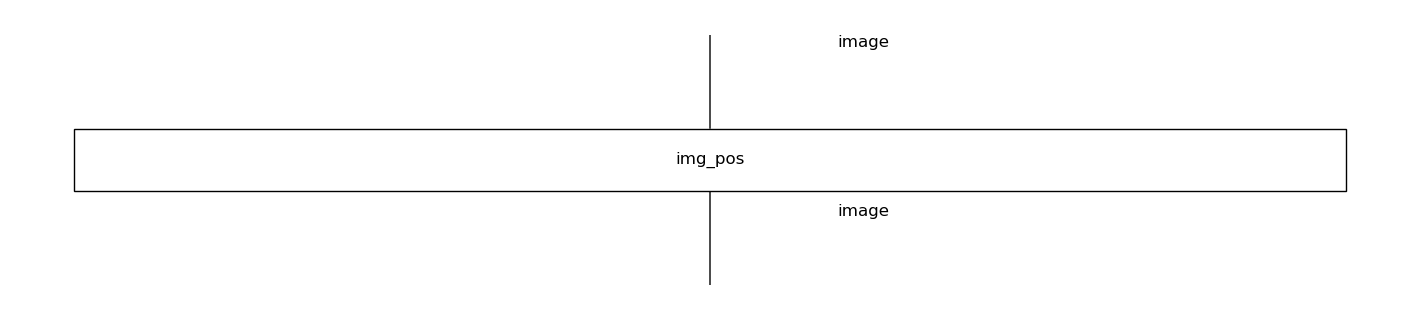

Image Diagram 2:
|Ty() @ [img_neg; Ty(image) -> Ty(image)] @ Ty()|


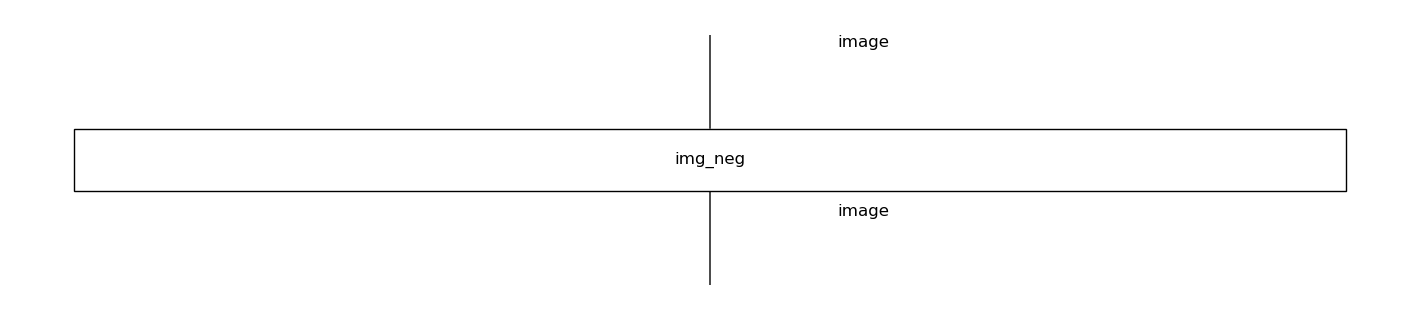

In [5]:
# Create a new box type using this syntactic category
class ImageBox(Box):
    def __init__(self, name, dom, cod, image=None):
        super().__init__(name, dom, cod)
        self.image = image

# Define a new syntactic category for images
image_type = Ty('image')  
image_box_pos = ImageBox('img_pos', image_type, image_type, image=images_array[0])
image_box_neg = ImageBox('img_neg', image_type, image_type, image=images_array[1])

# Create simple diagrams with the new box types
image_diagram_pos = Id(image_type) >> image_box_pos
image_diagram_neg = Id(image_type) >> image_box_neg

# Print and draw the image diagrams
print("Image Diagram 1:")
print(image_diagram_pos)
image_diagram_pos.draw(figsize=(14, 3), fontsize=12)

print("Image Diagram 2:")
print(image_diagram_neg)
image_diagram_neg.draw(figsize=(14, 3), fontsize=12)

Diagram presentation of the sentence

Sentence Diagram:
|Ty() @ Word(A, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Word(woman, ('Ty(n)', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Word(sits, ('Ty(n).r @ Ty(s)', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).r @ Ty(s) @ Word(in, ('Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l @ Word(a, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(field., ('Ty(n)', {'0'})) @ Ty()| >> |Ty(n) @ [CUP; Ty(n).l @ Ty(n) -> Ty()] @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n)| >> |Ty(n) @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l @ Ty(n) @ [CUP; Ty(n).l @ Ty(n) -> Ty()] @ Ty()| >> |Ty(n) @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ [CUP; Ty(n).l @ Ty(n) -> Ty()] @ Ty(

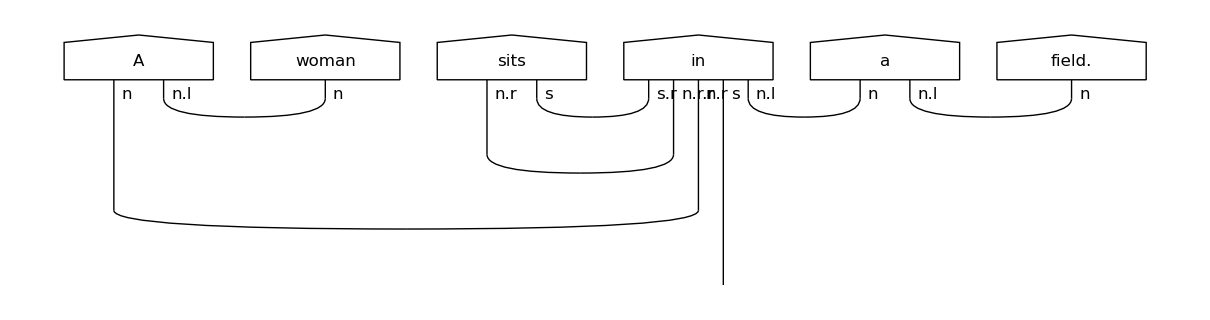

In [6]:
# Parse the sentence and convert it into a string diagram
sentence = df['sentence'].iloc[0]
parser = BobcatParser(verbose='suppress')
sentence_diagram = parser.sentence2diagram(sentence)

# Print and draw the sentence diagram
print("Sentence Diagram:")
print(sentence_diagram)
sentence_diagram.draw(figsize=(14, 3), fontsize=12)

Combined Diagram
|Ty() @ Word(A, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty(image) @ Ty(image)| >> |Ty(n) @ Ty(n).l @ Word(woman, ('Ty(n)', {'0'})) @ Ty(image) @ Ty(image)| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Word(sits, ('Ty(n).r @ Ty(s)', {'0'})) @ Ty(image) @ Ty(image)| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).r @ Ty(s) @ Word(in, ('Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l', {'0'})) @ Ty(image) @ Ty(image)| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l @ Word(a, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty(image) @ Ty(image)| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(field., ('Ty(n)', {'0'})) @ Ty(image) @ Ty(image)| >> |Ty(n) @ [CUP; Ty(n).l @ Ty(n) -> Ty()] @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(image) @ Ty(image)| >> |Ty(n) @ Ty(n).r @ Ty(s) @ Ty(s).r @ Ty(n).r.r @ Ty(n).r @ Ty(s) @ Ty(n).l @ Ty(n) @ [CUP; Ty(n).l @ Ty(n

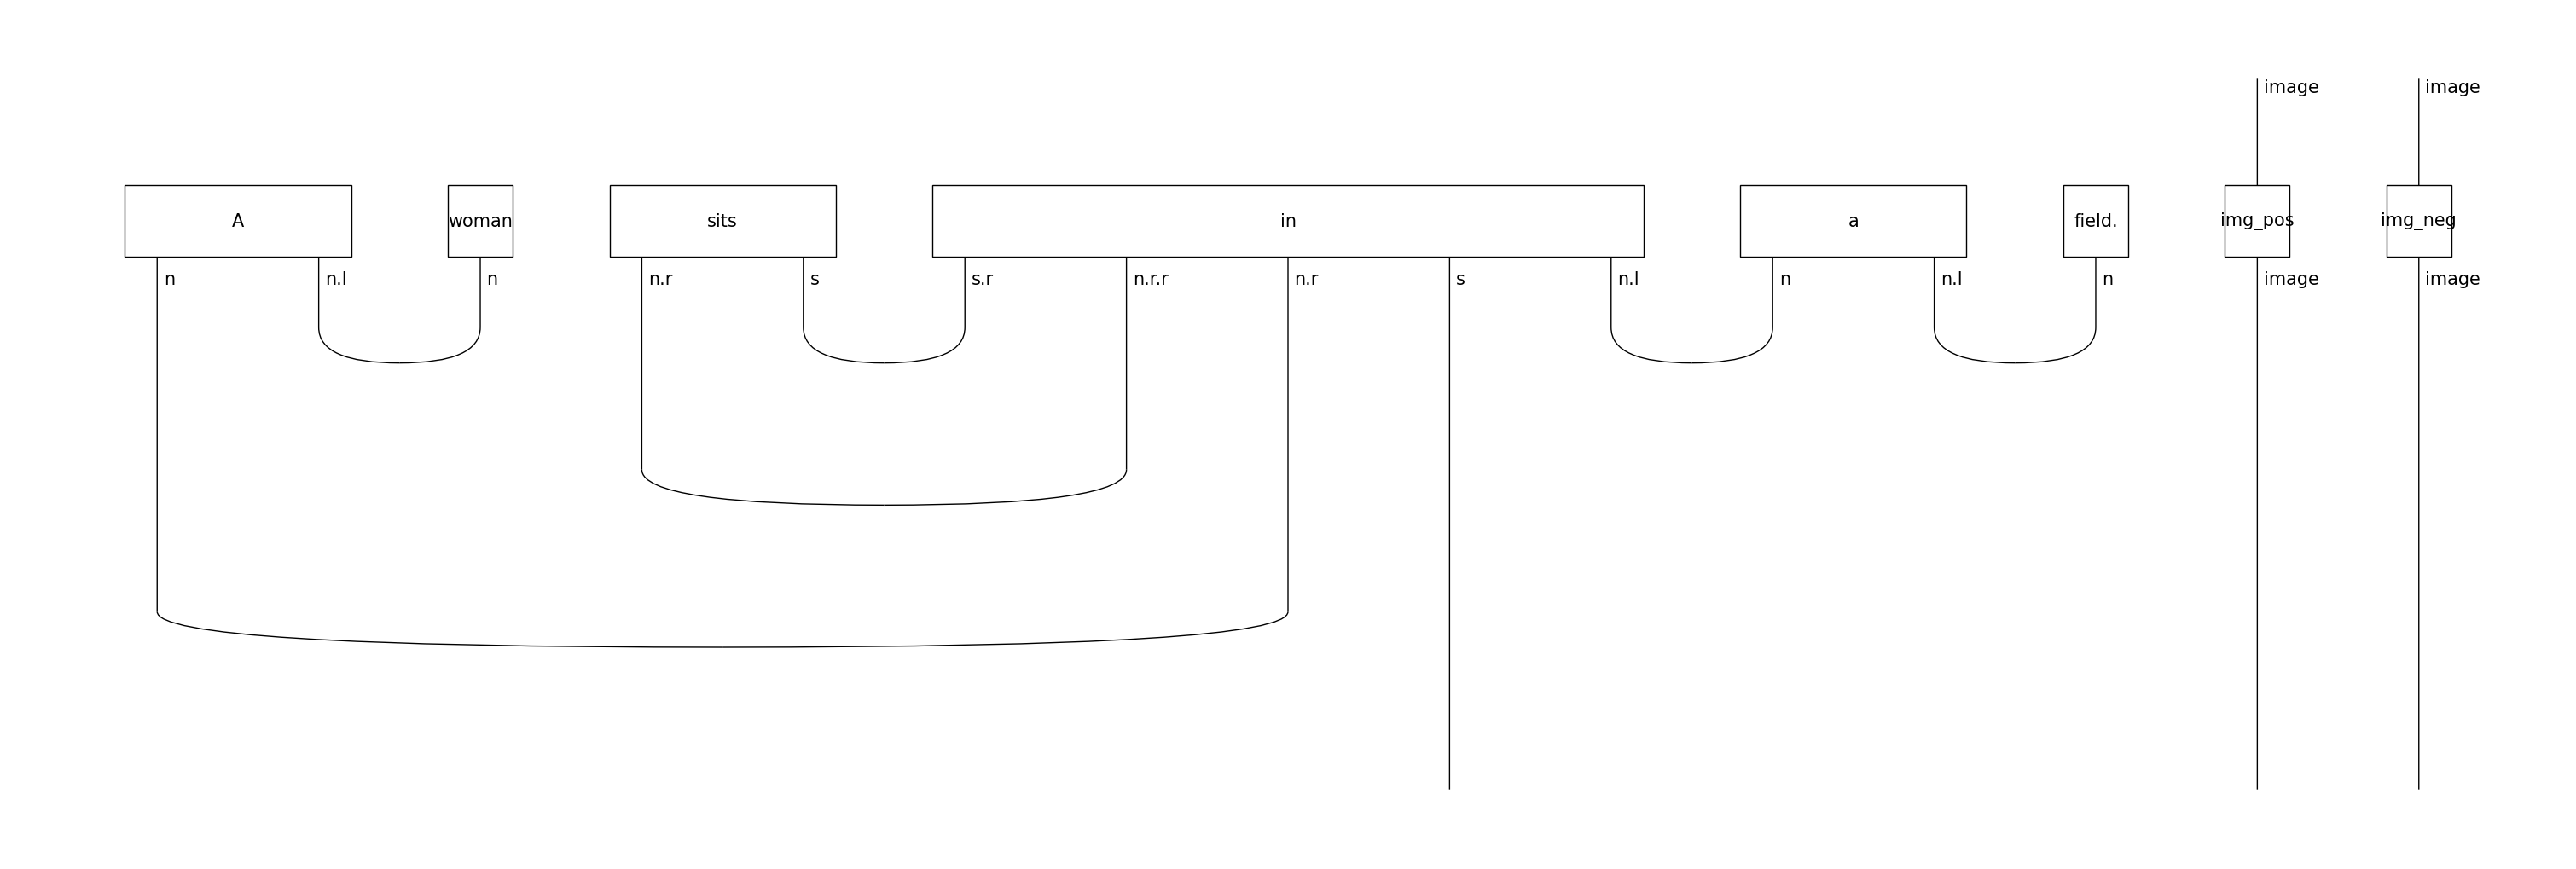

In [7]:
# Combine the sentence diagram with the image diagrams
combined_diagram1 = sentence_diagram @ image_diagram_pos
combined_diagram2 = combined_diagram1 @ image_diagram_neg

# Print and draw the combined diagrams
print("Combined Diagram")
print(combined_diagram2)
combined_diagram2.draw(figsize=(30, 10), fontsize=15)

#### TODO: 
- Add binary classification or label on image
- Merge the entire thing and feed it onto a network to learn the angle rotation, ansatz, and quantum parameters
